# Logistic Regression for E-Commerce Course Project

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

In [88]:
df = pd.read_csv('data/ecommerce_data.csv')
df.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


In [89]:
def get_data():
    df=pd.read_csv('data/ecommerce_data.csv')
    data=df.as_matrix()
    
    # split each row into features and label (the last column)
    X=data[:,:-1]
    Y=data[:,-1]
    
    # normalize column n_products_viewed and visti_duration
    X[:,1]=(X[:,1]-X[:,1].mean())/X[:,1].std()
    X[:,2]=(X[:,2]-X[:,2].mean())/X[:,2].std()

        
    # do the one-hot-encoding on column time_of_day
    N, D = X.shape
    X2=np.zeros((N, D + 3))
    X2[:, 0:(D-1)] = X[:, 0:(D-1)]

    
    # the time_of_day is the 5th column (0-based)
    for n in range(N):
        t = int(X[n,4])
        X2[n,t+D-1]=1
        
    return X2, Y

def get_binary_data():
    X, Y = get_data()
    X2=X[Y<=1]
    Y2=Y[Y<=1]
    return X2, Y2

In [90]:
X, Y = get_binary_data()
X, Y = shuffle(X, Y)

# hold 100 samples for testing
Xtrain = X[:-100]
Ytrain = Y[:-100]
Xtest = X[-100:]
Ytest = Y[-100:]

print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)


(298, 8)
(298,)
(100, 8)
(100,)


In [91]:
def forward(X, W):
    '''
    Compute the output of the Logistic Regression Network
    '''
    return sigmoid(X.dot(W))

def sigmoid(z):
    return 1/(1+np.exp(-z))

def classification_rate(Y, P):
    return np.mean(Y==P)

def cross_entropy(T, Y):
    J = 0;
    N = len(T)
    for i in range(N):
        if T[i] == 1:
            J-=np.log(Y[i])
        else:
            J-=np.log(1-Y[i])
    return J/N

# def cross_entropy(T, Y):
#     return -np.mean(T*np.log(Y) + (1-T)*np.log(1-Y))

In [92]:
def fit_ridge(X, T, epochs=100, learning_rate=0.1, lamba=0.1):
    
    N, D = X.shape
    
    # add bias 
    ones = np.ones((N,1))
    Xb = np.concatenate((X, ones), axis=1)

    # randomly initialize weights
    w = np.random.randn(D + 1)
    
    Y = forward(Xb, w)

    # training weights using gradient descent
    for i in range(epochs):
        if i % 10 == 0:
            print(i, cross_entropy(T, Y))
        
        w += learning_rate * (Xb.T.dot(T - Y) - lamba * w)
        Y = forward(Xb, w)

    return w

In [93]:
'''
If create a class for Logistic Regression, 
we can hold w as a interal object variable 
such that there is no need to pass in the weights w.
'''
def predict(X, T, w):
    N, D = X.shape
    
    # add bias 
    ones = np.ones((N,1))
    Xb = np.concatenate((X, ones), axis=1)

    
    Y = forward(Xb, w)
    
    print("classification rate:", classification_rate(T, np.round(Y)))
    

In [94]:
w = fit_ridge(Xtrain, Ytrain)
 
print("final w:", w, type(w))
predict(Xtrain, Ytrain, w)
predict(Xtest, Ytest, w)

0 1.08532758132
10 0.19313694999
20 0.173882095417
30 0.44092113747
40 0.228556271098
50 0.1822311929
60 0.173530344407
70 0.173203015252
80 0.173479613681
90 0.292778065194
final w: [ 1.8206699   8.39427415  0.72444741  2.47000937  0.57614225 -0.72158962
  0.10495549 -0.65666915 -0.47479969] <class 'numpy.ndarray'>
classification rate: 0.976510067114
classification rate: 0.95


## Logistic Regression with softmax (softmas regression)

In [130]:
def classification_rate(Y, P):
    return np.mean(Y==P)

def error_rate(T, P):
    return np.mean(T != P)

def softmax_cross_entropy(T, Y):
    return -(T * np.log(Y)).mean()

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

# one-hot-encoding on labels
def y2indicator(y, dims):
    N = len(y)
    y = y.astype(np.int32)
    
    # initialize the indicator matrix, 
    # N is the number of samples which dims is the number of classes
    ind = np.zeros((N, dims))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [146]:
class SoftmaxRegression(object):
    
    def __init__(self):
        pass
    
    def fit(self, X, Y, epochs=10000, learning_rate=0.001, reg=0.1, show_fig=False):
        X, Y = shuffle(X, Y)
        
        N, D = X.shape
        K = len(set(Y))
        
        # normally the split of data should be done before the fit method
        Xvalid, Yvalid = X[-100:], Y[-100:]
        X, Y = X[:-100], Y[:-100]
        
        T = y2indicator(Y, K)
        Tvalid = y2indicator(Yvalid, K)
        
        self.W1 = np.random.randn(D, K) / np.sqrt(D + K)
#         self.W1 = np.random.randn(D, K)
        self.b1 = np.zeros(K)
        
        costs = []
#         best_validation_error = 1
        best_classification_rate = 0
        for ep in range(epochs):
            
            Py = self.forward(X)
            
            Py_T = Py - T
            self.W1 -= learning_rate * (X.T.dot(Py_T) + reg * self.W1)
            self.b1 -= learning_rate * (Py_T.sum(axis=0) + reg * self.b1)
            
            
            Pyvalid = self.forward(Xvalid)
            c = softmax_cross_entropy(Tvalid, Pyvalid)
            costs.append(c)
                
            if ep % 1000 == 0:
#                 Pyvalid = self.forward(Xvalid)
#                 c = softmax_cross_entropy(Tvalid, Pyvalid)
#                 costs.append(c)
                cl = classification_rate(Yvalid, np.argmax(Pyvalid, axis=1))
                print("ep:", ep, "cost:", c, "classfication:", cl)
                if cl > best_classification_rate:
                    best_classification_rate = cl
                
        print("best_classification_rate:", best_classification_rate) 
        print("Final train classification rate:", classification_rate(Y, self.predict(X))) 
        print("Final test classification rate:", classification_rate(Yvalid, self.predict(Xvalid))) 
        
        if show_fig:
            plt.plot(costs)
            plt.show()              

    def forward(self, X):
        return softmax(X.dot(self.W1) + self.b1)
    
    def predict(self, X):
        Py = self.forward(X)
        return np.argmax(Py, axis=1)

ep: 0 cost: 0.315030951582 classfication: 0.47
ep: 1000 cost: 0.100148279431 classfication: 0.87
ep: 2000 cost: 0.0956286325591 classfication: 0.87
ep: 3000 cost: 0.0940821449067 classfication: 0.87
ep: 4000 cost: 0.0933683607299 classfication: 0.88
ep: 5000 cost: 0.0929861021298 classfication: 0.88
ep: 6000 cost: 0.0927641833303 classfication: 0.88
ep: 7000 cost: 0.092629233259 classfication: 0.88
ep: 8000 cost: 0.0925448806776 classfication: 0.88
ep: 9000 cost: 0.0924912705111 classfication: 0.88
best_classification_rate: 0.88
Final train classification rate: 0.93
Final test classification rate: 0.88


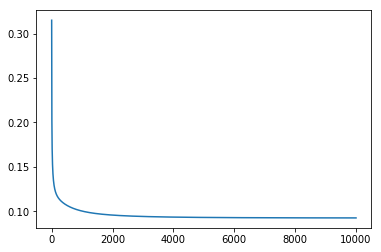

In [152]:
X, Y = get_data()

# print(X.shape)
model = SoftmaxRegression()
model.fit(X, Y, learning_rate=0.001, epochs=10000, reg=0.1, show_fig=True)
